In [1]:
import re
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 10

In [2]:
# the index of the simulated read for the case study and plot
signal_index = 55
simulation_data_run_name = "test_sim"

In [3]:
root_dir = "/home/bizon/tandem_repeats_finder"
align_dir = os.path.join(root_dir, simulation_data_run_name, "align")
signal_dir = os.path.join(root_dir, simulation_data_run_name, "signal")
output_dir = os.path.join(root_dir, 'data')

align_fn = os.path.join(align_dir, f"align_{signal_index}.ali")
signal_fn = os.path.join(signal_dir, f"signal_{signal_index}.txt")
sampled_fa_fn = os.path.join(root_dir, simulation_data_run_name, "sampled_read.fasta")

## Load sampled fasta

In [4]:
read_ind = []
read_seq = []
read_len = []
contain_tandem_repeats = []
repeats_start_end = []
with open(sampled_fa_fn, 'r') as f:
    for line in f:
        if line.startswith('>'):
            read_ind.append(int(line.strip('\n')[1:]))
        else:
            sampled_seq = line.strip('\n')
            read_seq.append(sampled_seq)
            read_len.append(len(sampled_seq))
            m = re.search(r"(CGC){10,}", sampled_seq)
            if m:
                contain_tandem_repeats.append(1)
                repeats_start_end.append(m.span())
            else:
                contain_tandem_repeats.append(0)
                repeats_start_end.append(())
fasta_df = pd.DataFrame(data={'id': read_ind,
                              'seq':read_seq,
                              'seq_len': read_len,
                              'contain_tandem_repeats': contain_tandem_repeats,
                              'repeats_start_end': repeats_start_end})

In [5]:
print(fasta_df.head())

   id                                                seq  seq_len  \
0   0  GACGCATCCGGCCCAGAGGGCCTCAAGGAAAGAGACGGTGGGGTGA...      162   
1   1  TCTTTTCTGCCAGAGAAGGCAGTTTGAGGGTTCTCCCCTCCATGAA...      412   
2   2  GCTCCATTGGCTCTGCGATTCCCCAAACCTCTGGCTCCGGGAGGAG...      491   
3   3  AACGCCACCAGGGGAAGACCGGGAGAGAAGAAACACGGGGTTAGCG...      356   
4   4                    CCCCTGCGTTCCCACCGGCCGGTACCTGTTC       31   

   contain_tandem_repeats repeats_start_end  
0                       0                ()  
1                       0                ()  
2                       0                ()  
3                       0                ()  
4                       0                ()  


In [6]:
print(f"mean length of simulated reads: {fasta_df.seq_len.mean()}")
print(f"number of reads w/ tandem repeats: {fasta_df.contain_tandem_repeats.value_counts().loc[1]}")
print(f"number of reads w/o tandem repeats: {fasta_df.contain_tandem_repeats.value_counts().loc[0]}")
print(fasta_df[fasta_df.contain_tandem_repeats==1])

mean length of simulated reads: 297.7742
number of reads w/ tandem repeats: 538
number of reads w/o tandem repeats: 4462
        id                                                seq  seq_len  \
28      28  AAGAGCCGCCCCTGCGTTCCCACCGGCCGGTACCTGTTCCAAGATC...      964   
39      39  TCACCATAGTCGGAGAGTCGAAAGCCGAATTCACTTAAATAATCAA...      642   
51      51  CGGCCCCGGCAGGTGAAAGAGCAGAGCGCGGCCCCGCCGCCGCCGC...      736   
55      55  AACACTCAGGGTAACAGTTTGGCAGGAGGGAGCGGGCGGGCGGGCG...      408   
68      68  GCGCGGCCCCGGCTTGGGGGCCCTGGCCGGGGGATCCGCGAGGCCC...      513   
...    ...                                                ...      ...   
4962  4962  CTGCCGGTAACACTCAGGGTAACAGTTTGGCAGGAGGGAGCGGGCG...      308   
4970  4970  CAGGAGCGGCCCGTCCCGGGCGGGCGCCGAGGCCGCGGCGGAGAAA...     1082   
4989  4989  TCGAAAGCCGAATTCACTTAAATAATCAACTTTCATAATACTTAAT...      343   
4994  4994  AACACTCAGGGTAACAGTTTGGCAGGAGGGAGCGGGCGGGCGGGCG...      361   
4996  4996  AATCAACTTTCATAATACTTAATTAATGCCTAATTGCAACTGATTA...    

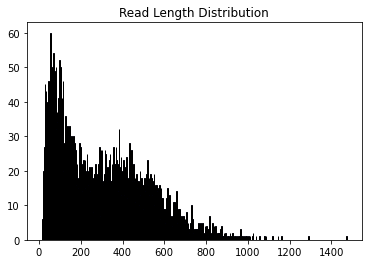

In [7]:
plt.hist(fasta_df.seq_len, bins=len(fasta_df)//10, color = 'blue', edgecolor = 'black')
plt.title('Read Length Distribution')
plt.show()

## Load align and signal file

In [8]:
align_df = pd.read_csv(align_fn, sep=" ", names=['signal_ind', 'base_ind'])
signal_df = pd.read_csv(signal_fn, names=['signal'])

In [9]:
print(align_df.base_ind.max())
print(len(signal_df) == align_df.signal_ind.max())

408
True


In [10]:
print(align_df.base_ind.value_counts())

393    40
53     26
19     24
319    21
100    20
       ..
249     2
41      2
89      2
62      2
168     1
Name: base_ind, Length: 408, dtype: int64


In [11]:
signal_df['signal_ind'] = signal_df.index + 1
signal_df = signal_df.merge(align_df, on='signal_ind', how='left')
signal_combined_df = signal_df.groupby('base_ind').agg({'signal': 'mean'})
signal_combined_df.reset_index(inplace = True)
bases = [base for base in fasta_df.loc[fasta_df.id==signal_index, 'seq'].item()]
signal_combined_df['base'] = bases

## Plot

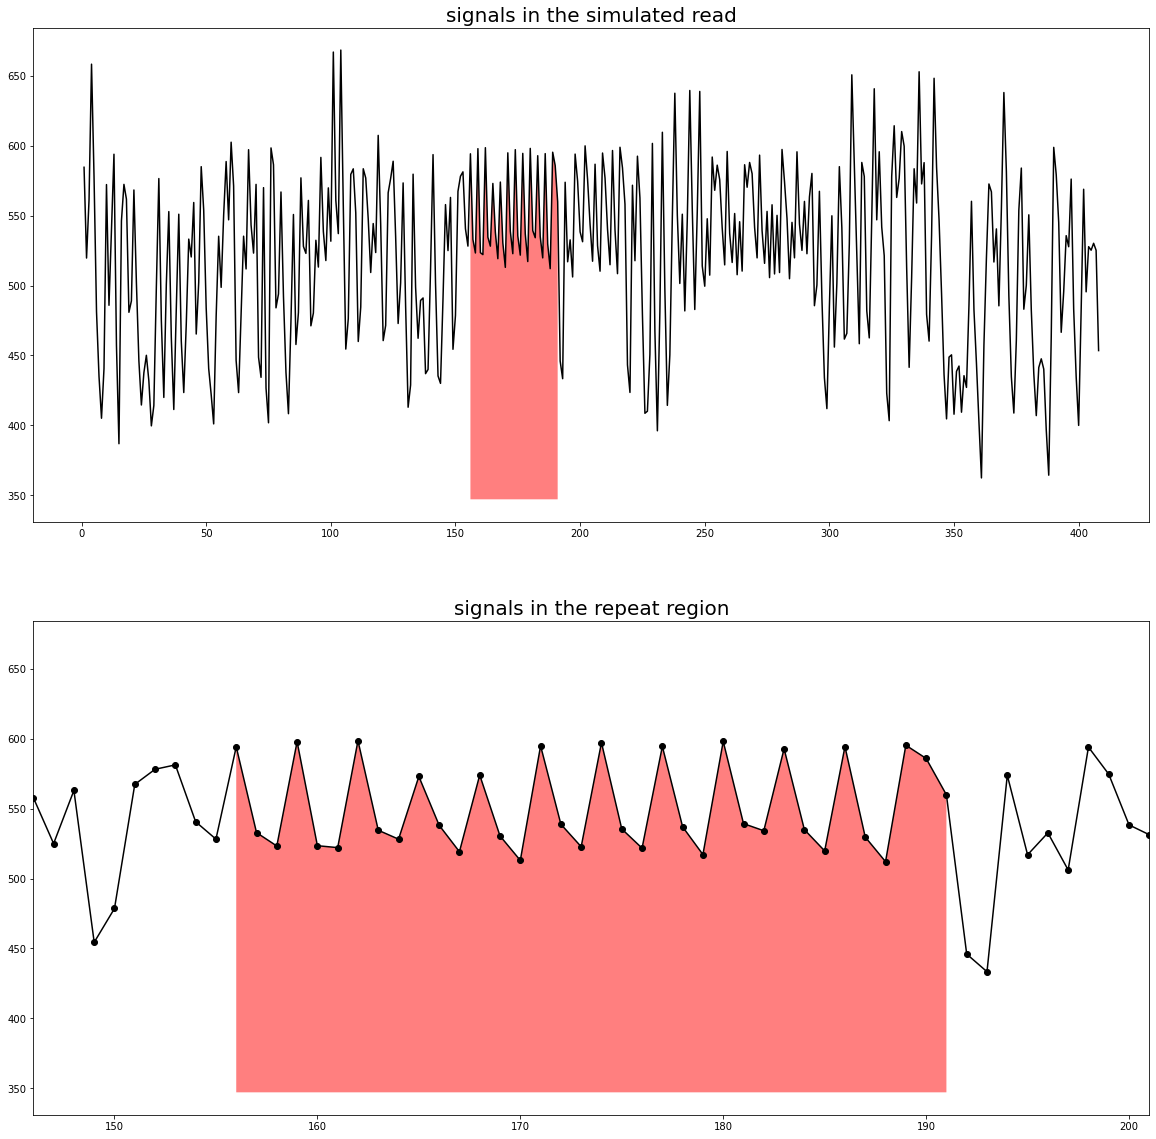

In [12]:
x = signal_combined_df['base_ind'].copy()
y = signal_combined_df['signal'].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# plot ax1
ax1.plot(x, y, color='black')
ymin = ax1.get_ylim()[0]
if (fasta_df.repeats_start_end[signal_index]):
    rep_start, rep_end = fasta_df.repeats_start_end[signal_index]
    ax1.fill_between(x, ymin, y, 
                    where= (x >= rep_start+1) & (x <= rep_end),
                    facecolor='red', 
                    alpha=0.5)
ax1.set_title("signals in the simulated read",
              fontsize = 20)

# plot ax2
if (fasta_df.repeats_start_end[signal_index]):
    ax2.plot(x, y, color='black', marker='o')
    ymin = ax2.get_ylim()[0]
    if (fasta_df.repeats_start_end[signal_index]):
        rep_start, rep_end = fasta_df.repeats_start_end[signal_index]
        ax2.fill_between(x, ymin, y, 
                        where= (x >= rep_start+1) & (x <= rep_end),
                        facecolor='red', 
                     alpha=0.5)

    """
    for coor, base in zip(list(zip(x, y)), signal_combined_df['base']):
        label = base
        ax2.annotate(label, # this is the text
                     coor, # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    """
    border_dist = 10
    ax2.set_xlim((rep_start+1-border_dist, rep_end+border_dist))
    ax2.set_title("signals in the repeat region",
                  fontsize = 20)

## Case Study

In [13]:
base_ind = 8
align_df.base_ind.value_counts()
signal_ind = align_df.loc[align_df.base_ind==base_ind, 'signal_ind'].to_numpy()
signal_ind = np.sort(signal_ind-1)

In [14]:
signal_df.iloc[signal_ind]

,signal,signal_ind,base_ind
64,396,65,8
65,397,66,8
66,397,67,8
67,405,68,8
68,390,69,8
69,402,70,8
70,423,71,8
71,431,72,8


## Generate training and testing set

In [15]:
all_aln_fns = os.listdir(align_dir)
read_indicies = [int(re.findall(r'\d+', aln_fn)[0]) for aln_fn in all_aln_fns]
read_indicies = sorted(read_indicies)
print(f"total num of simulated reads: {len(read_ind)}")

total num of simulated reads: 5000


In [16]:
def generate_signal_label_arr(align_dir, signal_dir, read_indicies, fasta_df, padding_tail=True):
    signals=[]
    labels=[]
    ind_label_dict = dict(zip(fasta_df['id'], fasta_df['contain_tandem_repeats']))
    for ind in read_indicies:
        align_fn = os.path.join(align_dir, f"align_{ind}.ali")
        signal_fn = os.path.join(signal_dir, f"signal_{ind}.txt")
        align_df = pd.read_csv(align_fn, sep=" ", names=['signal_ind', 'base_ind'])
        signal_df = pd.read_csv(signal_fn, names=['signal'])
        signal_df['signal_ind'] = signal_df.index + 1
        signal_df = signal_df.merge(align_df, on='signal_ind', how='left')
        signal_combined_df = signal_df.groupby('base_ind').agg({'signal': 'mean'})
        signal_combined_df.reset_index(inplace = True)
        signal_combined_df.sort_values('base_ind', inplace=True)
        signals.append(signal_combined_df['signal'].tolist())
        labels.append(ind_label_dict.get(ind))
        if (ind+1)%1000==0:
            print(f"{ind+1} simulated reads processed")
    max_seq_len = max([len(signal_vec) for signal_vec in signals])
    num_signals = len(signals)
    print("generating numpy array...")
    signals_arr = np.zeros((num_signals, max_seq_len), float)
    for i in range(len(signals)):
        if (padding_tail):
            signals_arr[i, 0:len(signals[i])] = signals[i]
        else:
            signals_arr[i, -len(signals[i]):] = signals[i]
    labels_arr = np.array(labels).reshape(-1, 1)
    data = np.concatenate((signals_arr, labels_arr), axis=1)
    print("performing train-test split...")
    X_train, X_test, y_train, y_test = train_test_split(signals_arr, 
                                                        labels_arr, 
                                                        train_size=0.75, 
                                                        stratify=labels_arr)
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test = generate_signal_label_arr(align_dir, 
                                                             signal_dir, 
                                                             read_indicies, 
                                                             fasta_df, 
                                                             padding_tail=False)
train = np.concatenate([X_train, y_train], axis=1)
test = np.concatenate([X_test, y_test], axis=1)

1000 simulated reads processed
2000 simulated reads processed
3000 simulated reads processed
4000 simulated reads processed
5000 simulated reads processed
generating numpy array...
performing train-test split...


In [18]:
# dump generated numpy array to csv
train_fn = os.path.join(output_dir, "train.csv")
test_fn = os.path.join(output_dir, "test.csv")

np.savetxt(train_fn, train, delimiter=",")
np.savetxt(test_fn, test, delimiter=",")